In [1]:
import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
from os.path import isfile, join
import glob

import keras 
import tensorflow as tf
print(tf.__version__)
import numpy as np
from matplotlib import pyplot as plt
from shutil import copyfile
from random import seed
from random import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.utils import image_dataset_from_directory,load_img
from keras.applications import vgg16
from pathlib import Path

import PIL
from PIL import Image, ImageOps

from sklearn.utils import shuffle
from sklearn import metrics

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
   
from keras.callbacks import LearningRateScheduler


2024-06-18 11:09:51.603010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 11:09:51.824598: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 11:09:52.663245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-18 11:09:52.663427: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

2.11.0


In [2]:
seed = 10
split = 0.2
img_rows, img_cols = 150, 150
path = './flowers'
labels = [fn.split('/')[2] for fn in [join(path,f) for f in listdir(path)]]

In [3]:

train_datagen = ImageDataGenerator(
    validation_split = split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    # preprocessing_function=to_grayscale_then_rgb
)

val_datagen = ImageDataGenerator(
    validation_split = split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    # preprocessing_function=to_grayscale_then_rgb
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # preprocessing_function=to_grayscale_then_rgb
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = 32, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)
num_class =train_generator.num_classes

Found 3457 images belonging to 5 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = 32, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 860 images belonging to 5 classes.


In [6]:
IMG_DIM = (img_rows, img_cols)

train_files = glob.glob('./flowers/daisy/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

Labels: ['10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e', '10994032453_ac7f8d9e2e']


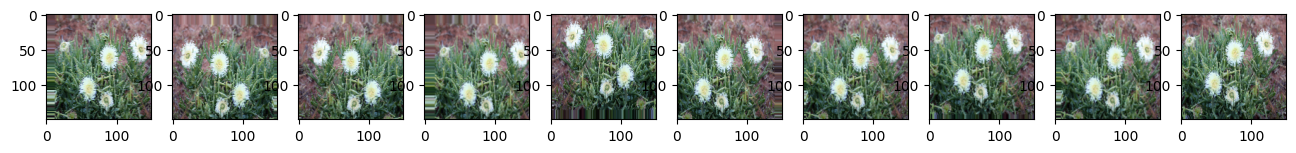

In [7]:
IMG_DIM = (img_rows, img_cols)

train_files = glob.glob('./flowers/daisy/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]
img_id  = np.random.randint(100)
diasy_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
diasy = [next(diasy_generator) for i in range(0,10)]
fig, ax = plt.subplots(1,10, figsize=(16, 6))
print('Labels:', [item[1][0] for item in diasy])
l = [ax[i].imshow(diasy[i][0][0]) for i in range(0,10)]

In [8]:
plt.style.use('seaborn-v0_8-dark')

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid(True)
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid(True)


keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
]

callbacks_list_ = [keras_callbacks]

In [28]:
from keras.applications import vgg16
input_shape = (img_rows, img_cols, 3)
vgg16_2 = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape,
                    classifier_activation='softmax')

output = vgg16_2.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_vgg16_2 = Model(vgg16_2.input, output)


basemodel_vgg16_2.trainable = True

set_trainable = False

for layer in basemodel_vgg16_2.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
        
    else:
        layer.trainable = False

In [29]:
basemodel_vgg16_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [30]:
model_vgg = Sequential()
model_vgg.add(basemodel_vgg16_2)
model_vgg.add(Dense(1048, activation='relu', input_dim=input_shape))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(128, activation='relu', input_dim=input_shape))
model_vgg.add(Dense(num_class, activation='softmax'))
                 
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
                 
                 
model_vgg.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_21 (Dense)            (None, 1048)              8586264   
                                                                 
 dropout_7 (Dropout)         (None, 1048)              0         
                                                                 
 dense_22 (Dense)            (None, 128)               134272    
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 23,435,869
Trainable params: 15,800,605
Non-trainable params: 7,635,264
_________________________________________________________________


In [31]:
model_vgg_history = model_vgg.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator,
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 938s 9s/step - loss: 1.4163 - accuracy: 0.4056 - val_loss: 1.1124 - val_accuracy: 0.6047
Epoch 2/60
109/109 [==============================] - 972s 9s/step - loss: 1.0212 - accuracy: 0.6127 - val_loss: 0.8300 - val_accuracy: 0.6860
Epoch 3/60
109/109 [==============================] - 1046s 10s/step - loss: 0.8147 - accuracy: 0.6934 - val_loss: 0.7209 - val_accuracy: 0.7186
Epoch 4/60
109/109 [==============================] - 1052s 10s/step - loss: 0.7263 - accuracy: 0.7333 - val_loss: 0.6564 - val_accuracy: 0.7488
Epoch 5/60
109/109 [==============================] - 1031s 9s/step - loss: 0.6487 - accuracy: 0.7579 - val_loss: 0.5866 - val_accuracy: 0.7721
Epoch 6/60
109/109 [==============================] - 992s 9s/step - loss: 0.5716 - accuracy: 0.7920 - val_loss: 0.5763 - val_accuracy: 0.7698
Epoch 7/60
109/109 [==============================] - 1055s 10s/step - loss: 0.5555 - accuracy: 0.8004 - val_loss: 0.5531 - val_accuracy:

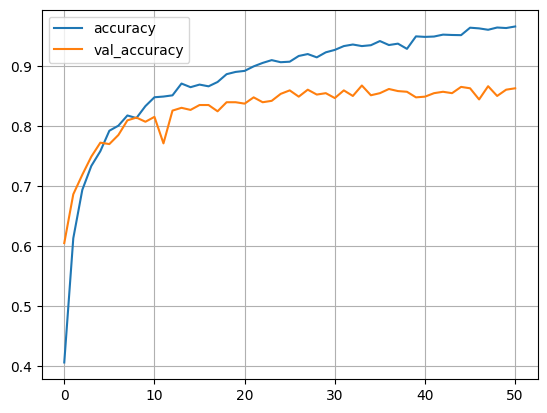

In [ ]:
plot_accuracy(model_vgg_history)

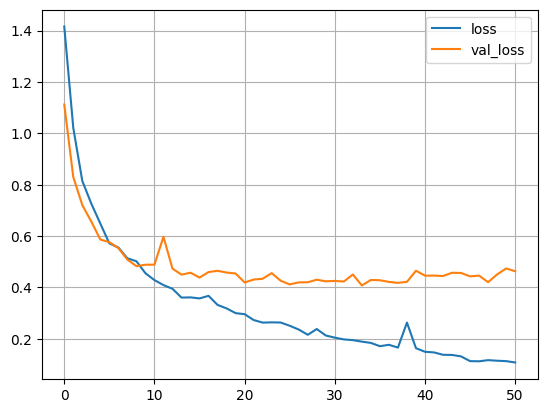

In [ ]:
plot_loss(model_vgg_history)

In [34]:
model_vgg.save('model_vgg_tuned')

INFO:tensorflow:Assets written to: model_vgg_tuned/assets


INFO:tensorflow:Assets written to: model_vgg_tuned/assets


In [12]:
model_vgg_tuned = tf.keras.models.load_model('model_vgg_tuned')

2024-06-18 09:08:10.710506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
from keras.applications import InceptionV3
input_shape = (img_rows, img_cols, 3)
Incept_2 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=num_class,
    classifier_activation="softmax"
)

output = Incept_2.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_Incept_2 = Model(Incept_2.input, output)

basemodel_Incept_2.summary()

2024-06-18 11:10:05.776948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
basemodel_Incept_2.trainable = True

set_trainable = False

for layer in basemodel_Incept_2.layers:
    if layer.name in ['conv2d_89','conv2d_86','conv2d_85']:
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
        
    else:
        layer.trainable = False
        

input_shape = basemodel_Incept_2.output_shape[1]

In [11]:
basemodel_Incept_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
model_incept = Sequential()
model_incept.add(basemodel_Incept_2)
model_incept.add(Dense(1048, activation='relu', input_dim=input_shape))
model_incept.add(Dropout(0.3))
model_incept.add(Dense(128, activation='relu', input_dim=input_shape,kernel_regularizer=keras.regularizers.l1(l=0.001)))
model_incept.add(Dense(num_class, activation='softmax'))
                 
                 
model_incept.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
                 
                 
model_incept.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 18432)             21802784  
                                                                 
 dense (Dense)               (None, 1048)              19317784  
                                                                 
 dropout (Dropout)           (None, 1048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               134272    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 41,255,485
Trainable params: 25,526,237
Non-trainable params: 15,729,248
_________________________________________________________________


In [13]:
model_incept_history = model_incept.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator, 
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 59s 524ms/step - loss: 6.0623 - accuracy: 0.4790 - val_loss: 5.6528 - val_accuracy: 0.6814
Epoch 2/60
109/109 [==============================] - 68s 625ms/step - loss: 5.6549 - accuracy: 0.6754 - val_loss: 5.4830 - val_accuracy: 0.7430
Epoch 3/60
109/109 [==============================] - 74s 681ms/step - loss: 5.5151 - accuracy: 0.7139 - val_loss: 5.4380 - val_accuracy: 0.7570
Epoch 4/60
109/109 [==============================] - 74s 686ms/step - loss: 5.4255 - accuracy: 0.7483 - val_loss: 5.3662 - val_accuracy: 0.7663
Epoch 5/60
109/109 [==============================] - 76s 698ms/step - loss: 5.3366 - accuracy: 0.7859 - val_loss: 5.3225 - val_accuracy: 0.7965
Epoch 6/60
109/109 [==============================] - 88s 808ms/step - loss: 5.2851 - accuracy: 0.7885 - val_loss: 5.3153 - val_accuracy: 0.7791
Epoch 7/60
109/109 [==============================] - 79s 726ms/step - loss: 5.2396 - accuracy: 0.8100 - val_loss: 5.2718 - val_ac

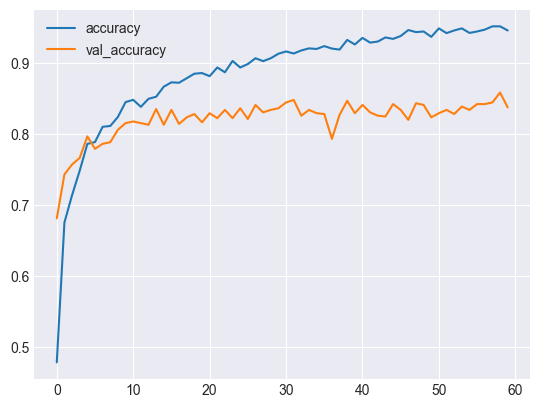

In [14]:
plot_accuracy(model_incept_history)

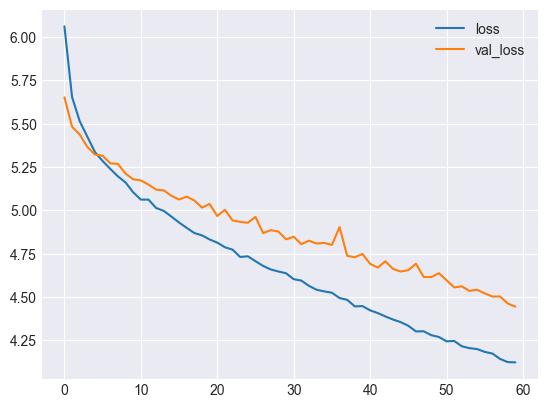

In [15]:
plot_loss(model_incept_history)

In [16]:
model_incept.save('model_incept_tuned')

INFO:tensorflow:Assets written to: model_incept_tuned/assets


INFO:tensorflow:Assets written to: model_incept_tuned/assets


In [17]:
model_incept_tuned = tf.keras.models.load_model('model_incept_tuned')

In [ ]:
from keras.applications import ResNet152V2

input_shape = (img_rows, img_cols, 3)
res_2 = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=num_class,
    classifier_activation="softmax"
)

output = res_2.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_res2 = Model(res_2.input, output)


basemodel_res2.trainable = False
for layer in basemodel_res2.layers: 
    layer.trainable = False

input_shape = basemodel_res2.output_shape[1]
basemodel_res2.summary()

2024-06-17 18:03:10.987060: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
basemodel_res2.trainable = True

set_trainable = False

for layer in basemodel_res2.layers:
    if layer.name in ['conv5_block3_3_conv', 'conv5_block3_2_conv']:
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
        
    else:
        layer.trainable = False

In [ ]:
model_res = Sequential()
model_res.add(basemodel_res2)
model_res.add(Dense(1048, activation='relu', input_dim=input_shape))
model_res.add(Dropout(0.3))
model_res.add(Dense(128, activation='relu', input_dim=input_shape,kernel_regularizer=keras.regularizers.l1(l=0.001)))
model_res.add(Dense(num_class, activation='softmax'))
                 
                 
model_res.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
                 
                
model_res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 51200)             58331648  
                                                                 
 dense (Dense)               (None, 1048)              53658648  
                                                                 
 dropout (Dropout)           (None, 1048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               134272    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 112,125,213
Trainable params: 57,208,605
Non-trainable params: 54,916,608
_________________________________________________________________


In [12]:
model_res_history = model_res.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator, 
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 556s 5s/step - loss: 5.8739 - accuracy: 0.5901 - val_loss: 5.5184 - val_accuracy: 0.7244
Epoch 2/60
109/109 [==============================] - 562s 5s/step - loss: 5.4728 - accuracy: 0.7426 - val_loss: 5.4180 - val_accuracy: 0.7628
Epoch 3/60
109/109 [==============================] - 536s 5s/step - loss: 5.3636 - accuracy: 0.7752 - val_loss: 5.3331 - val_accuracy: 0.7872
Epoch 4/60
109/109 [==============================] - 587s 5s/step - loss: 5.2639 - accuracy: 0.8076 - val_loss: 5.3136 - val_accuracy: 0.7942
Epoch 5/60
109/109 [==============================] - 651s 6s/step - loss: 5.1685 - accuracy: 0.8314 - val_loss: 5.2899 - val_accuracy: 0.8070
Epoch 6/60
109/109 [==============================] - 639s 6s/step - loss: 5.1544 - accuracy: 0.8371 - val_loss: 5.2590 - val_accuracy: 0.8058
Epoch 7/60
109/109 [==============================] - 665s 6s/step - loss: 5.0739 - accuracy: 0.8658 - val_loss: 5.2449 - val_accuracy: 0.8093

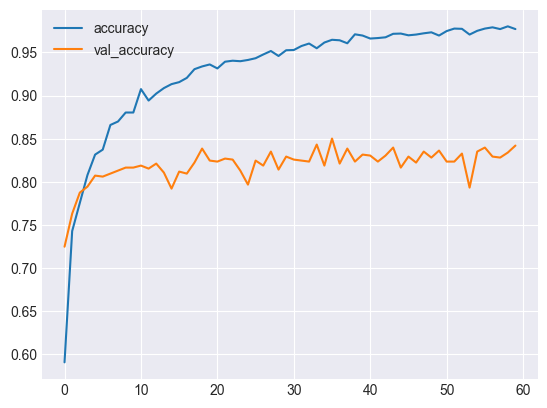

In [13]:
plot_accuracy(model_res_history)

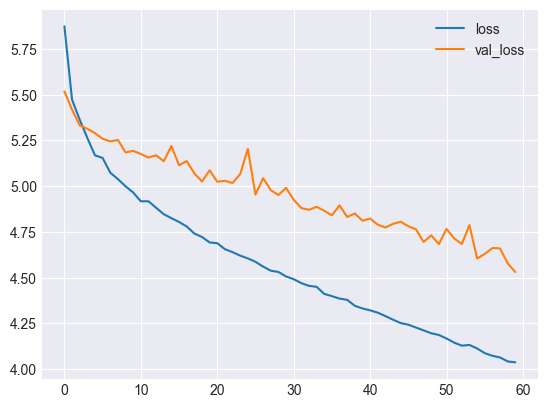

In [14]:
plot_loss(model_res_history)

In [15]:
model_res.save('model_res_tuned')

INFO:tensorflow:Assets written to: model_res_tuned/assets


INFO:tensorflow:Assets written to: model_res_tuned/assets


In [26]:
model_res_tuned = tf.keras.models.load_model('model_res_tuned')

In [18]:
def model_report(model,test_img):
    predicts = model.predict(test_img)
    predicts_labels = [ labels[np.argmax(score)] for score in predicts ]
    
    
#     #Preview Predicts Image
    fig1, ax1 = plt.subplots(1,5,figsize=(25,5))
    ax1= ax1.flatten()
    fig1.suptitle("Image with Predicted Labels", fontsize=18)
    l1 = [ax1[i].imshow(test_img[i]) for i in range(5)]
    l1_label = [ax1[i].set_xlabel(predicts_labels[i]) for i in range(5)]
    
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test_labels,predicts_labels,normalize='true'),display_labels=labels)
    disp.plot()
    plt.show()
  
                
                


In [19]:
from sklearn.utils import shuffle
pics = list()
pics_arr = list()
p_class = list()
files = list()

data_dir = Path("flowers")



# plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    for file in shuffle(list(data_dir.glob(folder.name+'/*')))[0:150]:
        files.append(file)
    
files = shuffle(files)
    
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(str(img), target_size=IMG_DIM)) for img in files]
test_imgs = np.array(test_imgs)
test_labels = [fn.parts[1] for fn in files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255   
    

24/24 [==============================] - 18s 691ms/step


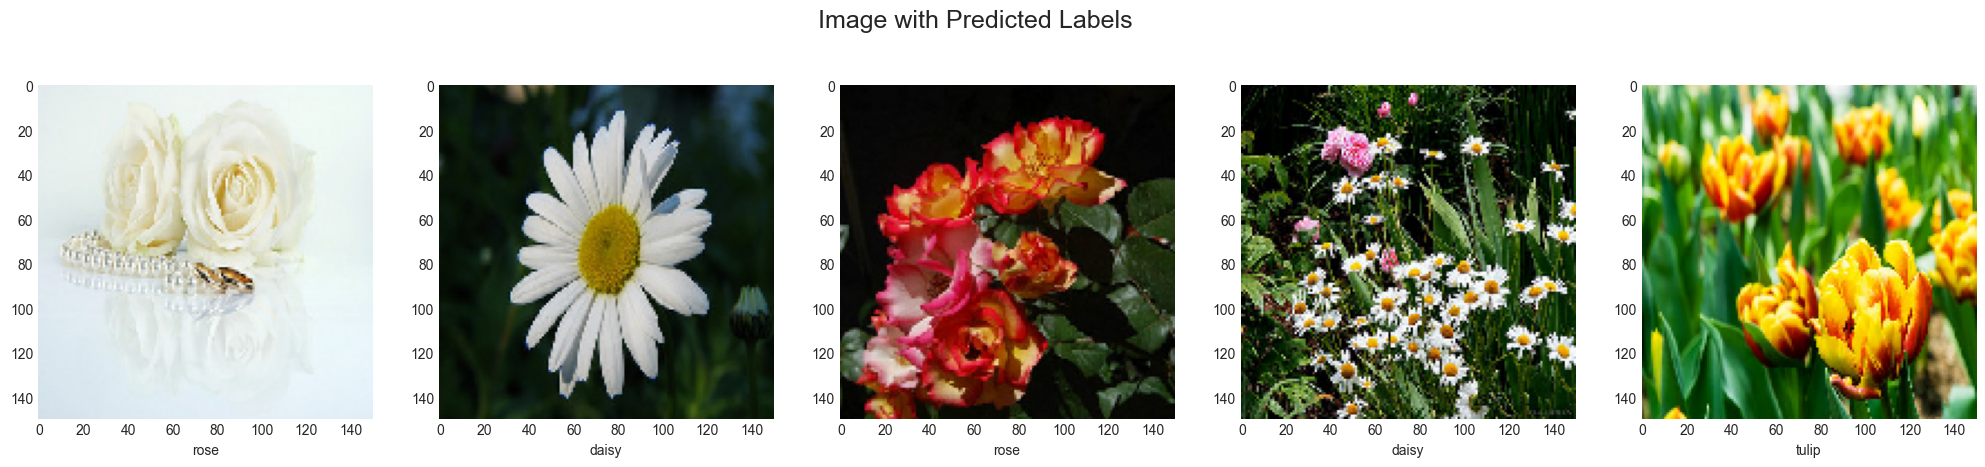

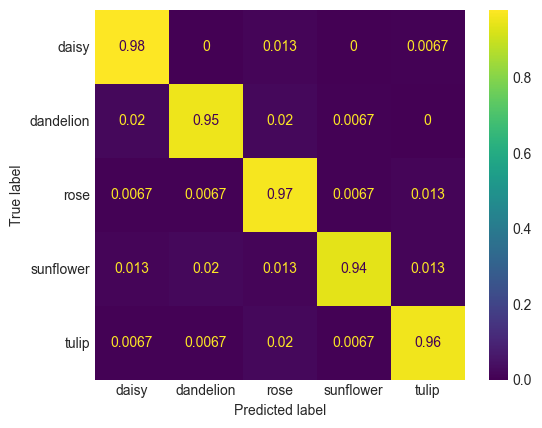

In [20]:
model_report(model_incept_tuned,test_imgs_scaled)